In [1]:
import pandas as pd
import numpy as np

import statsmodels.stats.proportion as proportion
import scipy.stats as ss
from scipy.stats import mannwhitneyu
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.auto import tqdm

import requests
from urllib.parse import urlencode

plt.style.use('ggplot')

# Задание 1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Входные данные:
* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Загрузим наши данные.

In [2]:
def get_download_url(path):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = path

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    return download_url

In [3]:
groups_path = get_download_url('https://disk.yandex.ru/d/58Us0DWOzuWAjg')
groups_add_path = get_download_url('https://disk.yandex.ru/d/3aARY-P9pfaksg')
active_studs_path = get_download_url('https://disk.yandex.ru/d/prbgU-rZpiXVYg')
checks = get_download_url('https://disk.yandex.ru/d/84hTmELphW2sqQ')

In [4]:
groups = pd.read_csv(groups_path, sep=';')
groups_add = pd.read_csv(groups_add_path)
active_studs = pd.read_csv(active_studs_path)
checks = pd.read_csv(checks, sep=';')

## 1.1. Препроцессинг данных

Посмотрим на наши данные

In [5]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [6]:
groups.shape

(74484, 2)

In [7]:
groups.nunique()

id     74484
grp        2
dtype: int64

In [8]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [9]:
groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [10]:
groups_add.shape

(92, 2)

In [11]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [12]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [13]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [14]:
active_studs.shape

(8341, 1)

In [15]:
active_studs.nunique()

student_id    8341
dtype: int64

In [16]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [17]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [18]:
checks.shape

(541, 2)

In [19]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [20]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [21]:
checks.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


!!! Из описательной статиститики видим, что наш минимальный чек равен 199, а не 0, запомним, это будет важно дальше.

В active_studs и checks другое название колонки с id, переименуем их. Это необходимо для дальнейших объединений датафреймов.

In [22]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

Дополнительный файл с пользователями о принадлежности к контрольной или целевой группе объединим с исходным.

In [23]:
groups_new = pd.concat([groups, groups_add], ignore_index=True, sort=False)
groups_new

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Посмотрим размеры наших групп

In [24]:
users_by_group = groups_new \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'}) \
    .rename(columns={'id': 'sum_id'})
users_by_group

,grp,sum_id
0,A,14693
1,B,59883


Добавим колонку в процентном соотношении для наглядности

In [25]:
users_by_group['percentage'] = round((users_by_group.sum_id / users_by_group.sum_id.sum() * 100), 2)
users_by_group

,grp,sum_id,percentage
0,A,14693,19.7
1,B,59883,80.3


Добавим в active_studs колонку с активностью пользователей, где 1 - пользователь заходил на сайт в дни проведения эксперимента

In [26]:
active_studs['active'] = 1

Так как в active_studs нет данных о принадлежности к контрольной или целевой группе, то объединим этот датафрейм с groups_new и оставим только данные о тех пользователях, которые зашли в дни проведения эксперимента.

In [27]:
active_users = active_studs.merge(groups_new, how='inner', on='id')

In [28]:
active_users

,id,active,grp
0,581585,1,A
1,5723133,1,A
2,3276743,1,B
3,4238589,1,A
4,4475369,1,B
...,...,...,...
8336,1794344,1,B
8337,296883,1,B
8338,3598448,1,B
8339,3610547,1,B


Проверим, не потеряли ли мы строки при объединении

In [29]:
active_users.shape[0] == active_studs.shape[0]

True


Посмотрим, как распределилось количество зашедших пользователей.

In [30]:
active_users_by_group = active_users \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'}) \
    .rename(columns={'id': 'sum_id'})
active_users_by_group

,grp,sum_id
0,A,1538
1,B,6803


И в процентном соотношении.

In [31]:
active_users_by_group['percentage'] = round((active_users_by_group.sum_id / active_users_by_group.sum_id.sum() * 100), 2)
active_users_by_group

,grp,sum_id,percentage
0,A,1538,18.44
1,B,6803,81.56


В checks у нас также нет данных о принадлежности к контрольной или целевой группе, объединим этот датафрейм с groups_new и оставим только данные о тех пользователях, которые совершили оплату в дни проведения эксперимента.

In [32]:
checks_with_id = checks.merge(groups_new, how='inner', on='id')

In [33]:
checks_with_id.shape

(541, 3)

И, наконец, создадим финальный датасет, где объединим active_users c checks_with_id.

In [34]:
final_users = active_users.merge(checks_with_id, how='outer', on=['id', 'grp'])

In [35]:
final_users

,id,active,grp,rev
0,581585,1.0,A,NaN
1,5723133,1.0,A,NaN
2,3276743,1.0,B,NaN
3,4238589,1.0,A,NaN
4,4475369,1.0,B,NaN
...,...,...,...,...
8485,5291900,NaN,B,199.0
8486,5331842,NaN,B,290.0
8487,5486319,NaN,B,199.0
8488,5562806,NaN,B,398.0


In [36]:
final_users.isna().sum()

id           0
active     149
grp          0
rev       7949
dtype: int64

У нас есть 149 пользователей, которые не заходили на платформу в дни проведения эксперимента, но при этом совершали покупки. Посмотрим более внимательно.

In [37]:
nonactive_users_with_checks = final_users \
    .query('active != 1') \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'}) \
    .rename(columns = {'id': 'sum_id'})
nonactive_users_with_checks

,grp,sum_id
0,A,29
1,B,120


In [38]:
nonactive_users_with_checks['percentage'] = round((nonactive_users_with_checks.sum_id / nonactive_users_with_checks.sum_id.sum() * 100), 2)
nonactive_users_with_checks

,grp,sum_id,percentage
0,A,29,19.46
1,B,120,80.54


In [39]:
active_users_by_group

,grp,sum_id,percentage
0,A,1538,18.44
1,B,6803,81.56


Так как у нас пользователи были распределены по группам заранее, то можно предположить, что они оформили заказ до проведения эксперимента, а сама оплата прошла во время эксперимента.

Еще, как вариант, можно было бы предположить, что у тех пользователей, которые не заходили на сайт, но были покупки, был настроен автоплатеж.

Еще можно предположить, что данные о поведении пользователей на сайте берутся, например, из одной системы, а данные об оплатах берутся из другой системы, и в какой-то момент не сработала система, отслеживающая поведение пользователей на сайте, то есть произошла техническая ошибка. Так же на техническую ошибку, на мой взгляд указывает тот факт, что у нас практически одинаковый процент распределения по группам и у пользователей, которые зашли на платформу в дни проведения эксперимента, и у пользователей, которые не зашли на платформу, но при этом оплатили.

## 1.2. Выбор и расчет метрики

Посмотрим на наши данные из checks. Все, что мы знаем, это то, что в нем содержатся данные об оплатах пользователей в дни проведения эксперимента.

In [40]:
checks.head(3)

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


У нас две колонки. В одной содержатся id пользователей, в другой данный об оплатах. Посмотрим более детально на оплаты.

In [41]:
checks.rev.unique()

array([ 990.    ,  690.    ,  630.    ,  580.    ,  290.    , 1140.    ,
       1900.0001,  199.    ,  398.    , 1830.    , 1900.    , 3260.    ,
       2910.    , 2820.    , 2099.    , 3660.    , 1530.    , 2900.    ,
       1980.    , 1160.    ,  870.    ,  840.    , 2890.    , 1180.    ,
        880.    , 3040.    ,  796.    , 4650.    , 2190.    , 1729.    ,
       1388.    ,  590.    , 2220.    ,  489.    , 1050.    , 1968.    ,
       1339.    ,  597.    , 1039.    ])

Можем предположить, что так как колонка называется rev, то это revenue, то есть доход, который принес пользователь, но мы не знаем сколько покупок совершил пользователь. Если этой в колонке rev у нас один чек, то в таком случае такие метрики как средний чек и ARPPU у нас будут равны. 

* Средний чек = доход / количество покупок
* ARPPU = доход / клиенты (платящие пользователи)

Будем считать, что каждый пользователь совершил одну покупку и в колонке revenue у нас сумма этой покупки.

Также можно посмотреть на конверсию в покупку. Конверсия (conversion rate) – отношение числа пользователей, совершивших целевое действие на определенном этапе, к общему числу тех, кто дошел до данного этапа. В нашем случае отношение числа пользователей, совершивших покупку, и к общему числу тех, кто зашел на сайт.

Рассчитаем метрики. Для начала если у нас нет значений (пользователь заходил на сайт, но не совершил покупку), то удалим сразу NaN. Для дальнейшего анализа, удалим также пользователей, которые не заходили на сайт, но совершили покупку (но вообще-то в реальных условиях надо бы разобраться, что произошло). 

In [42]:
final_users_dropna = final_users.dropna()

In [43]:
final_users_dropna

,id,active,grp,rev
62,1184303,1.0,A,1530.0000
67,3354191,1.0,B,1900.0001
77,3278734,1.0,B,1900.0000
99,720651,1.0,A,1980.0000
193,1232221,1.0,B,1900.0000
...,...,...,...,...
8201,3890326,1.0,B,199.0000
8204,1390994,1.0,A,398.0000
8263,1516339,1.0,A,290.0000
8277,3910596,1.0,B,597.0000


In [44]:
buy_id = final_users_dropna \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'}) \
    .rename(columns={'id': 'buy_id'})
buy_id

,grp,buy_id
0,A,78
1,B,314


In [45]:
revenue = final_users_dropna \
    .groupby('grp', as_index=False) \
    .agg({'rev': 'sum'})
revenue

,grp,rev
0,A,72820.0000
1,B,394974.0035


In [46]:
avg_check = final_users_dropna \
    .groupby('grp', as_index=False) \
    .agg({'rev': 'mean'}) \
    .round(2) \
    .rename(columns={'rev': 'avg_check'})
avg_check

,grp,avg_check
0,A,933.59
1,B,1257.88


In [47]:
come_id = active_users_by_group.rename(columns={'sum_id': 'come_id'})
come_id

,grp,come_id,percentage
0,A,1538,18.44
1,B,6803,81.56


In [48]:
metrics = come_id.merge(buy_id, on='grp'). merge(revenue, on='grp').merge(avg_check, on='grp')
metrics

,grp,come_id,percentage,buy_id,rev,avg_check
0,A,1538,18.44,78,72820.0000,933.59
1,B,6803,81.56,314,394974.0035,1257.88


In [49]:
metrics['ARPPU'] = round(metrics.rev / metrics.buy_id, 2)
metrics['CR'] = round(metrics.buy_id / metrics.come_id * 100, 2) 
metrics

,grp,come_id,percentage,buy_id,rev,avg_check,ARPPU,CR
0,A,1538,18.44,78,72820.0000,933.59,933.59,5.07
1,B,6803,81.56,314,394974.0035,1257.88,1257.88,4.62


## 1.3. Средний чек

### 1.3.1. Формируем статистические гипотезы

Нулевая гипотеза (H0): Разницы между средним чеком на сайте в контрольной и целевой группе нет.

Альтернативная гипотеза (H1): Разница между средним чеком на сайте в контрольной и целевой группе есть.

### 1.3.2. Выбираем метод A/B тестирования

Выбираем метод A/B–тестирования. Какой у нас тип данных? Переменная количественная. Какой у нас тип исследовательского вопроса? Поиск различий (differences). Что сравниваем? Средние значения (means). Сколько групп для сравнения? Две. Можем применить:

1. T-test (t-критерий Стьюдента)
2. U-критерий Манна-Уитни
3. Бутсрап

Для начала посмотрим на нормальность распределения данных.

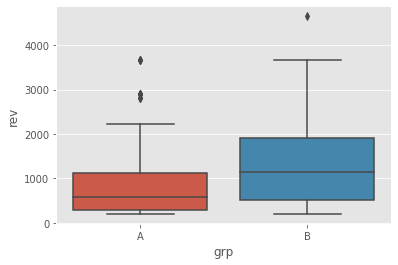

In [50]:
sns.boxplot(x='grp', y='rev', data=final_users_dropna);

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


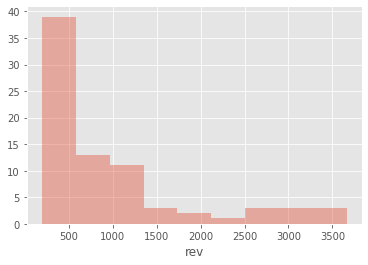

In [51]:
sns.distplot(final_users_dropna[final_users_dropna.grp == 'A'].rev, kde=False);

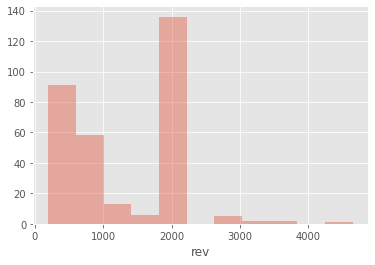

In [52]:
sns.distplot(final_users_dropna[final_users_dropna.grp == 'B'].rev, kde=False);

Из графиков выше мы видим:
* данные распределены не симметрично
* на третьем графике у нас явно две моды
* в наших данных есть выбросы.

Чтобы применить t-критерий Стьюдента нужно помнить о требовании к нормальности данных обеих групп при применении t-теста. Во многих учебниках можно встретить довольно жесткое требование к нормальности данных по причине возможного завышения вероятности ошибки I рода. 
Однако на практике t-тест может быть использован для сравнения средних и при ненормальном распределении, но для этого должны быть достаточно большие выборки и в данных не должно быть заметных выбросов. У нас же ненормальные данные, небольшие выборки и есть заметные выбросы. Как итог, t-тест мы не можем использовать. Но мы можем использовать его непараметрический аналог или бутстрап. 

### 1.3.3. Тестируем наши гипотезы

In [53]:
# Критерий Манна-Уитни
mannwhitneyu(final_users_dropna[final_users_dropna.grp == 'A'].rev,
             final_users_dropna[final_users_dropna.grp == 'B'].rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

In [54]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрап-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

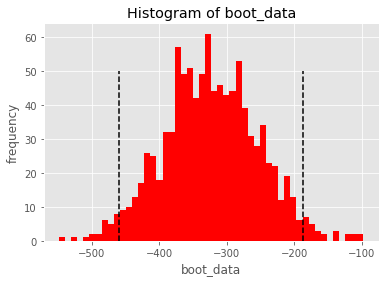

{'quants':                 0
 0.025 -458.883215
 0.975 -187.476284,
 'p_value': 3.4129945285813634e-06}

In [55]:
# Будстрап - среднее
get_bootstrap(
    final_users_dropna[final_users_dropna.grp == 'A'].rev,  # числовые значения первой выборки
    final_users_dropna[final_users_dropna.grp == 'B'].rev, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрап-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

### 1.3.4. Вывод

U-Критерий Манна-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки. Проблема критерия Манна-Уитни, что его сложно интерпертировать.

* И контрольная, и целевая выборка имеет большие выбросы, что сильно искажает нам среднее значение.
* Применяя бутстрап с оценкой среднего, мы можем отклонить нулевую гипотезу о равенстве средних и сделать вывод, что контрольная и целевая выборка имеют статистически значимые различия. (p_value < 0,05).
* U-критерий Манна-Уитни так же дает нам право отклонить нулевую гипотезу. (pvalue < 0,05).

Очень хочется сразу сказать, что раскатываем новый алгоритм на всех, так как средний чек статистически значимо изменился. Но принимать решение по одной метрике чаще всего будет ошибочной стратегией, необходимо обратить внимание на те метрики, которые могли бы улучшиться, так и ухудшиться, и смотреть на результат в комплексе. Как мы помним, при расчете метрик, у нас упал процент конверсии. Поэтому сравним еще конверсии

## 1.4. Конверсия

### 1.4.1. Формируем статистические гипотезы

- Нулевая гипотеза (H0): статитистически значимой разницы в проценте конверсии двух групп нет 
- Альтернативная гипотеза (H1): статитистически значимая разница в проценте конверсии двух групп есть

### 1.4.2. Выбираем метод A/B тестирования

Так как у нас две категориальные переменные, то используем Хи-квадрат для конверсии

### 1.4.3. Тестируем наши гипотезы

In [56]:
metrics

,grp,come_id,percentage,buy_id,rev,avg_check,ARPPU,CR
0,A,1538,18.44,78,72820.0000,933.59,933.59,5.07
1,B,6803,81.56,314,394974.0035,1257.88,1257.88,4.62


Нам нужно передать количество "успехов", в нашем случае это количество покупок пользователей, и количество попыток, в нашем случае это количество заходов на сайт.

In [57]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics.buy_id, metrics.come_id)

In [58]:
chi2stat, pval

(0.5821513741106591, 0.44547028437158964)

In [59]:
alpha = 0.05

In [60]:
print (pval < alpha)

False


### 1.4.4. Вывод

Нулевую гипотезу отклонить не можем, статистически значимой разницы в проценте конверсии двух групп не обнаружено. Какой общий вывод мы можем сделать на основе анализа двух метрик?

## 1.5. Общий вывод

У нас статистически значимо вырос средний чек, при этом упал процент конверсии, но статистической разницы в проценте конверсии двух групп обнаружено не было, и вроде бы можно раскатывать новую систему оплаты на сайте на всех пользователей, но есть ряд вопросов:

1. Насколько хорошо работает система сплитования? Правильно ли сформированы группы? Потому что у нас всего 20% в контрольной группе и 80% в целевой группе, и это выглядит очень странно.
2. Мы ничего не знаем о периоде проведения эксперимента, но исходя из наших данных, кажется, что он проходил слишком малое количество времени. Ну то есть предположим, что наши данные - это данные за первые 2 дня эксперимента. У нас зафиксирован статистически значимый результат по среднему чеку и не значимый результат по конверсии. Мы сейчас принем результат как успешный, а после раскатки изменений на всех пользователей ключевые показатели изменятся в худшую сторону. Таким образом, есть риск принять ложноположительное решение по среднему чеку (ошибка I рода) и ложноотрицательное решение по конверсии (ошибка II рода).
3. У нас есть 149 пользователей, которые совершили покупку в дни проведения эксперимента, но при этом не заходили на сайт. Как это произошло?

Ну то есть прежде чем раскатывать новую систему оплаты на сайте на всех пользователей, надо сначала ответить на предыдущие три вопроса.

# Задание 2. Python

## 2.1. 
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [61]:
def recalculate_metrics(groups, groups_add, active_studs, checks):

    groups_add.rename(columns={groups_add.columns[0]: 'id', groups_add.columns[1]: 'grp'}, inplace=True)

    groups_new = pd.concat([groups, groups_add], ignore_index=True, sort=False)

    active_studs = active_studs.rename(columns={'student_id': 'id'})
    checks = checks.rename(columns={'student_id': 'id'})

    active_users = active_studs.merge(groups_new, how='inner', on='id')
    
    active_users_by_group = active_users \
        .groupby('grp', as_index=False) \
        .agg({'id': 'count'}) \
        .rename(columns={'id': 'sum_id'})
    
    final_users = active_users.merge(checks, how='outer', on='id')

    final_users_dropna = final_users.dropna()

    buy_id = final_users_dropna \
        .groupby('grp', as_index=False) \
        .agg({'id': 'count'}) \
        .rename(columns={'id': 'buy_id'})

    revenue = final_users_dropna \
        .groupby('grp', as_index=False) \
        .agg({'rev': 'sum'})

    avg_check = final_users_dropna \
        .groupby('grp', as_index=False) \
        .agg({'rev': 'mean'}) \
        .round(2) \
        .rename(columns={'rev': 'avg_check'})

    come_id = active_users_by_group.rename(columns={'sum_id': 'come_id'})

    metrics = come_id.merge(buy_id, on='grp').merge(revenue, on='grp').merge(avg_check, on='grp')

    metrics['ARPPU'] = round(metrics.rev / metrics.buy_id, 2)
    metrics['CR'] = round(metrics.buy_id / metrics.come_id * 100, 2)
    
    return metrics

In [62]:
recalculate_metrics(groups, groups_add, active_studs, checks)

,grp,come_id,buy_id,rev,avg_check,ARPPU,CR
0,A,1538,78,72820.0000,933.59,933.59,5.07
1,B,6803,314,394974.0035,1257.88,1257.88,4.62


## 2.2.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [63]:
def visualize_metrics(df):
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(19,5))
    
    sns.barplot(x=df.grp, y=df.avg_check, palette="vlag", ax=ax1)   
    ax1.axhline(0, color="k", clip_on=False)
    ax1.set_title("Средний чек")
    ax1.set_ylabel("")
    ax1.set_xlabel("")
    
    sns.barplot(x=df.grp, y=df.CR, palette="vlag", ax=ax2)
    ax2.axhline(0, color="k", clip_on=False)
    ax2.set_title("Конверсия")
    ax2.set_ylabel("")
    ax2.set_xlabel("")
    ax2.set_yticklabels([str(i) + '%' for i in ax2.get_yticks()])
    
    sns.despine(bottom=True)
    plt.tight_layout(h_pad=2)

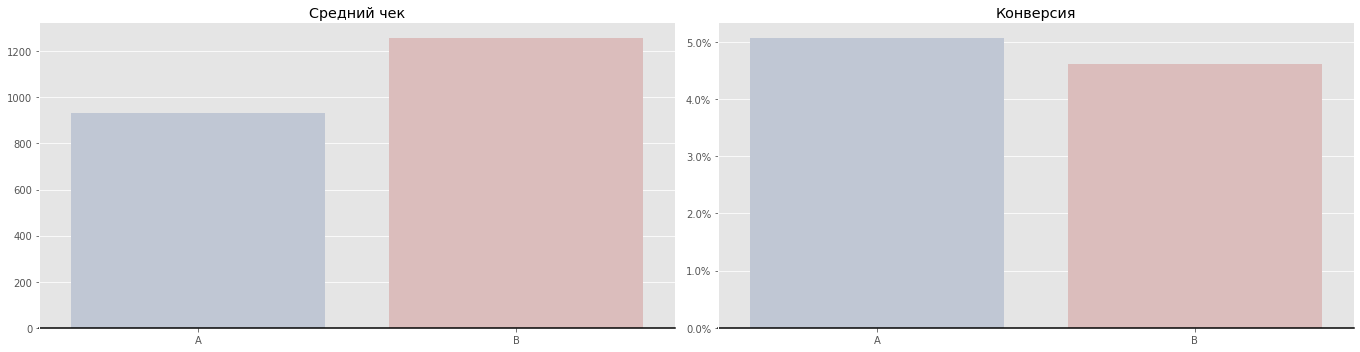

In [64]:
visualize_metrics(metrics)